In [42]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import img_as_ubyte  # type: ignore
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage import filters, transform  # type: ignore

# canvas_size = (150, 220)
# canvas_size = (952, 1360)
canvas_size = (300, 440)

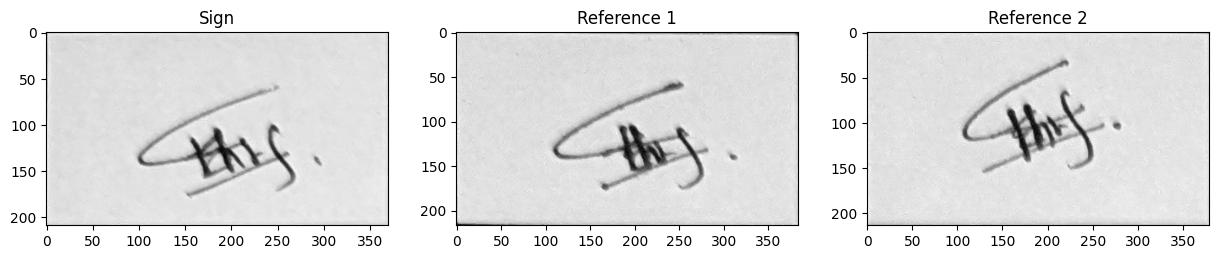

In [43]:
sign = cv2.imread(
    "../../tmp/processed/attendance/6504c0a30267c540afff568a/0/eg_2018_0159.png",
    cv2.IMREAD_GRAYSCALE,
)
ref_1 = cv2.imread(
    "../../tmp/processed/reference_sign_sheets/1694808563737/0/eg_2018_0159_0.png",
    cv2.IMREAD_GRAYSCALE,
)
ref_2 = cv2.imread(
    "../../tmp/processed/reference_sign_sheets/1694808563737/0/eg_2018_0159_1.png",
    cv2.IMREAD_GRAYSCALE,
)


f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sign, cmap="gray")
ax[0].set_title("Sign")
ax[1].imshow(ref_1, cmap="gray")
ax[1].set_title("Reference 1")
ax[2].imshow(ref_2, cmap="gray")
ax[2].set_title("Reference 2")
plt.show()

In [44]:
from typing import Tuple
from skimage import filters, transform  # type: ignore

import numpy as np


def preprocess_signature(
    img: np.ndarray,
    canvas_size: Tuple[int, int],
    img_size: Tuple[int, int] = (170, 242),
    input_size: Tuple[int, int] = (150, 220),
) -> np.ndarray:
    """Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.

    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.

    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------

    """
    img = img.astype(np.uint8)
    # remove 10px from each side but keeping the same center
    height, width = img.shape
    margin = 10
    img = img[margin : height - margin, margin : width - margin]

    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray, canvas_size=(840, 1360)) -> np.ndarray:
    """Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.

    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size

    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # # remove 10px from each side but keeping the same center
    # height, width = img.shape
    # img = img[10 : height - 10, 10 : width - 10]

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min() : r.max(), c.min() : c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    # print("Image size: ", img_rows, img_cols)
    # print("Canvas size: ", max_rows, max_cols)

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        # print(
        #     "Warning: cropping image. The signature should be smaller than the canvas size"
        # )
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start : crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        # print(
        #     "Warning: cropping image. The signature should be smaller than the canvas size"
        # )
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start : crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[
        r_start : r_start + img_rows, c_start : c_start + img_cols
    ] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
    """Remove noise using OTSU's method.

    Parameters
    ----------
    img : np.ndarray
        The image to be processed

    Returns
    -------
    np.ndarray
        The image with background removed
    """

    img = img.astype(np.uint8)
    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    img[img > threshold] = 255

    return img


def resize_image(img: np.ndarray, size) -> np.ndarray:
    """Crops an image to the desired size without stretching it.

    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size

    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(
        img,
        (resize_height, resize_width),
        mode="constant",
        anti_aliasing=True,
        preserve_range=True,
    )

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width - width) / 2.0))
        return img[:, start : start + width]
    else:
        start = int(round((resize_height - height) / 2.0))
        return img[start : start + height, :]


def crop_center(img: np.ndarray, size) -> np.ndarray:
    """Crops the center of an image

    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size: tuple (H x W)
        The desired size

    Returns
    -------
    np.ndarray
        The cRecentropped image
    """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y : start_y + size[0], start_x : start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray, size) -> np.ndarray:
    """Crops the center of multiple images

    Parameters
    ----------
    imgs : np.ndarray (N x C x H_old x W_old)
        The images to be cropped
    size: tuple (H x W)
        The desired size

    Returns
    -------
    np.ndarray (N x C x H x W)
        The cropped images
    """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y : start_y + size[0], start_x : start_x + size[1]]
    return cropped

Text(0.5, 1.0, 'Reference 2')

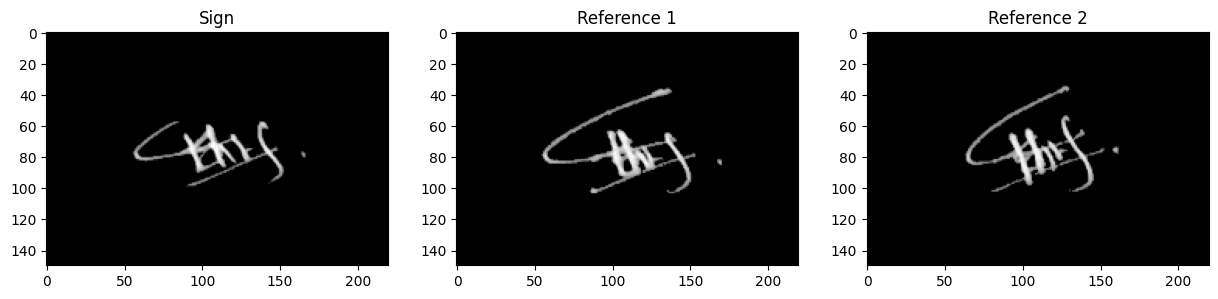

In [45]:
# from services_sign_process.preprocess import preprocess_signature


normalized_sign = preprocess_signature(sign, canvas_size)
normalized_ref_1 = preprocess_signature(ref_1, canvas_size)
normalized_ref_2 = preprocess_signature(ref_2, canvas_size)

f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(normalized_sign, cmap="gray")
ax[0].set_title("Sign")
ax[1].imshow(normalized_ref_1, cmap="gray")
ax[1].set_title("Reference 1")
ax[2].imshow(normalized_ref_2, cmap="gray")
ax[2].set_title("Reference 2")

In [46]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [47]:
def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

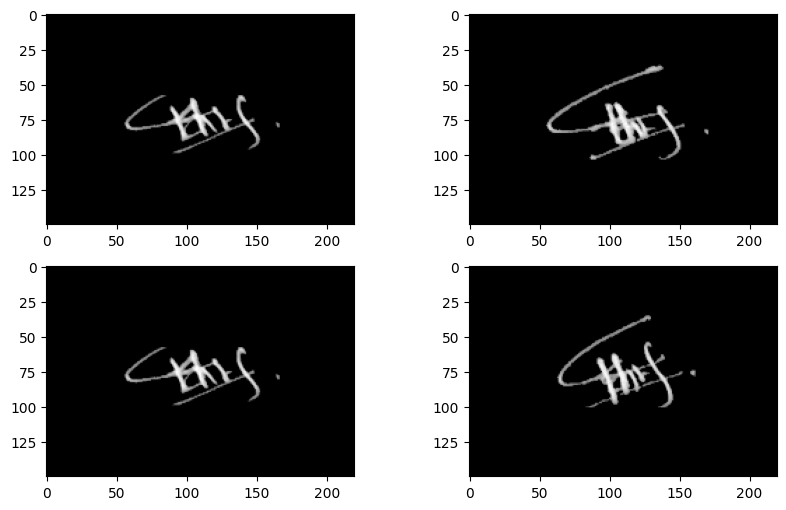

In [48]:
# sign = cv2.imread('../../tmp/processed/attendance/6504c0a30267c540afff568a/0/eg_2018_0159.png', cv2.IMREAD_GRAYSCALE)
# ref_1 = cv2.imread( '../../tmp/processed/reference_sign_sheets/1694808563737/0/eg_2018_0159_0.png', cv2.IMREAD_GRAYSCALE)
# ref_2 = cv2.imread( '../../tmp/processed/reference_sign_sheets/1694808563737/0/eg_2018_0159_1.png', cv2.IMREAD_GRAYSCALE)

# from preprocessing import preprocess_signature

user1_sigs = [
    load_signature(
        "../../tmp/processed/attendance/6504c0a30267c540afff568a/0/eg_2018_0159.png"
    ),
    load_signature(
        "../../tmp/processed/reference_sign_sheets/1694808563737/0/eg_2018_0159_0.png"
    ),
]
user2_sigs = [
    load_signature(
        "../../tmp/processed/attendance/6504c0a30267c540afff568a/0/eg_2018_0159.png"
    ),
    load_signature(
        "../../tmp/processed/reference_sign_sheets/1694808563737/0/eg_2018_0159_1.png"
    ),
]

processed_user1_sigs = torch.tensor(
    [preprocess_signature(sig, canvas_size) for sig in user1_sigs]
)
processed_user2_sigs = torch.tensor(
    [preprocess_signature(sig, canvas_size) for sig in user2_sigs]
)

f, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0, 0].imshow(processed_user1_sigs[0], cmap="gray")
ax[0, 1].imshow(processed_user1_sigs[1], cmap="gray")

ax[1, 0].imshow(processed_user2_sigs[0], cmap="gray")
ax[1, 1].imshow(processed_user2_sigs[1], cmap="gray")

processed_user1_sigs = processed_user1_sigs.view(-1, 1, 150, 220).float().div(255)
processed_user2_sigs = processed_user2_sigs.view(-1, 1, 150, 220).float().div(255)

In [49]:
from signet import SigNet

# Load the model
state_dict, _, _ = torch.load("./signet.pth")
base_model = SigNet().to(device).eval()
base_model.load_state_dict(state_dict)

<All keys matched successfully>

In [50]:
with torch.no_grad():
    user1_features = base_model(processed_user1_sigs.to(device))
    user2_features = base_model(processed_user2_sigs.to(device))

Student: eg_2018_0159.png
Cosine Similarity 1: 0.8135025501251221
Cosine Similarity 2: 0.8264851570129395
Cosine Average: 0.8199938535690308


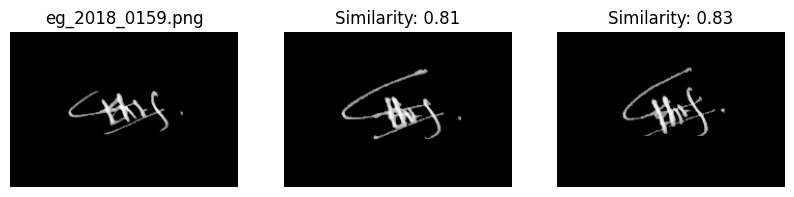

Student: eg_2018_0198.png
Cosine Similarity 1: 0.6344892382621765
Cosine Similarity 2: 0.6564791798591614
Cosine Average: 0.645484209060669


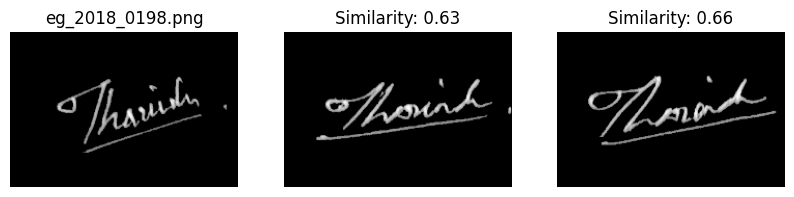

Student: eg_2018_0402.png
Cosine Similarity 1: 0.7320483922958374
Cosine Similarity 2: 0.6856688261032104
Cosine Average: 0.7088586091995239


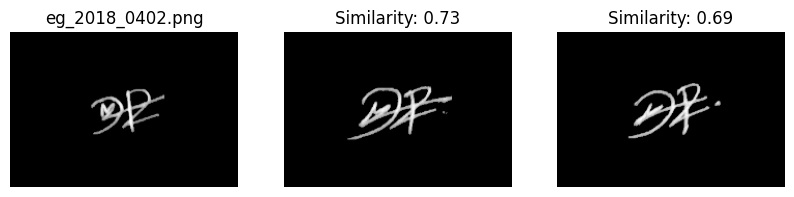

Student: eg_2018_0628.png
Cosine Similarity 1: 0.841106116771698
Cosine Similarity 2: 0.9219251275062561
Cosine Average: 0.881515622138977


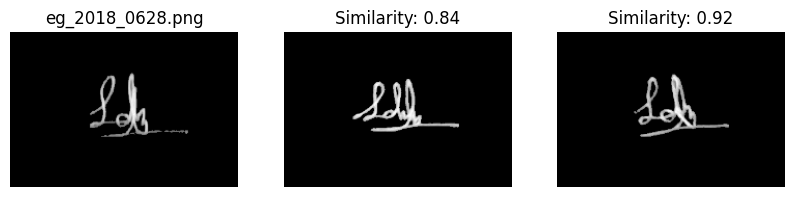

Student: eg_2018_0806.png
Cosine Similarity 1: 0.6520301103591919
Cosine Similarity 2: 0.7188699841499329
Cosine Average: 0.6854500472545624


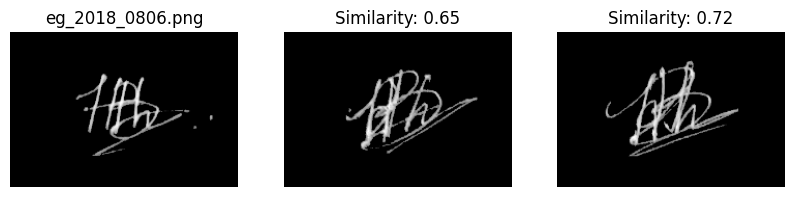

Student: eg_2018_0947.png
Cosine Similarity 1: 0.8029313683509827
Cosine Similarity 2: 0.7721284627914429
Cosine Average: 0.7875299155712128


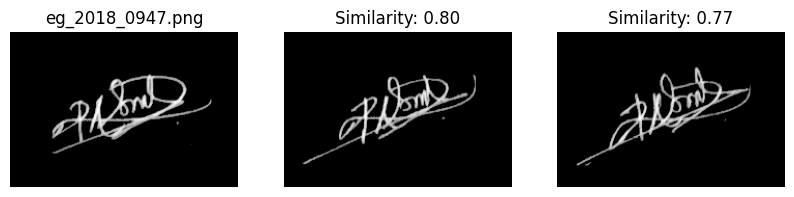

Student: eg_2018_1529.png
Cosine Similarity 1: 0.770840585231781
Cosine Similarity 2: 0.8737486004829407
Cosine Average: 0.8222945928573608


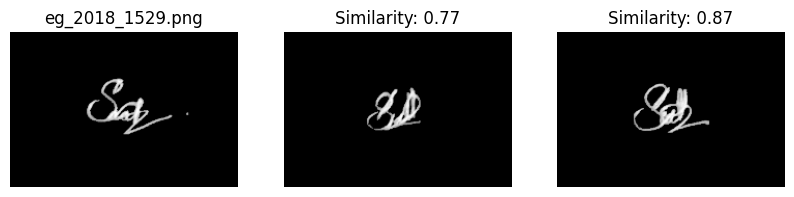

Student: eg_2018_1840.png
Cosine Similarity 1: 0.8270312547683716
Cosine Similarity 2: 0.7916482090950012
Cosine Average: 0.8093397319316864


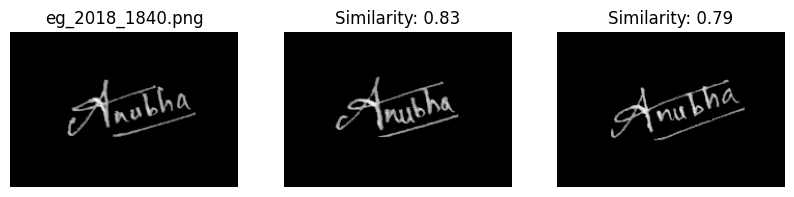

Student: eg_2018_2170.png
Cosine Similarity 1: 0.8096372485160828
Cosine Similarity 2: 0.6817081570625305
Cosine Average: 0.7456727027893066


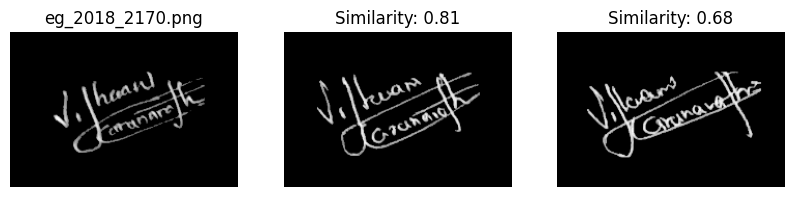

Student: eg_2018_2347.png
Cosine Similarity 1: 0.8545407056808472
Cosine Similarity 2: 0.7993142604827881
Cosine Average: 0.8269274830818176


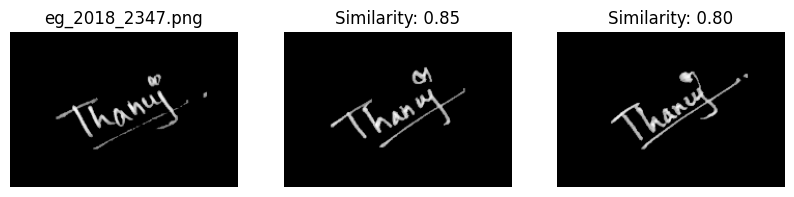

Student: eg_2018_2432.png
Cosine Similarity 1: 0.28244584798812866
Cosine Similarity 2: 0.25460293889045715
Cosine Average: 0.2685243934392929


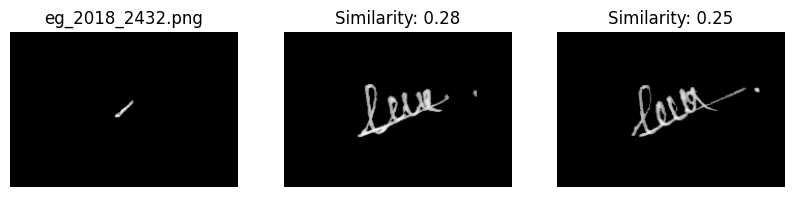

Student: eg_2018_2491.png
Cosine Similarity 1: 0.7089002132415771
Cosine Similarity 2: 0.7591156363487244
Cosine Average: 0.7340079247951508


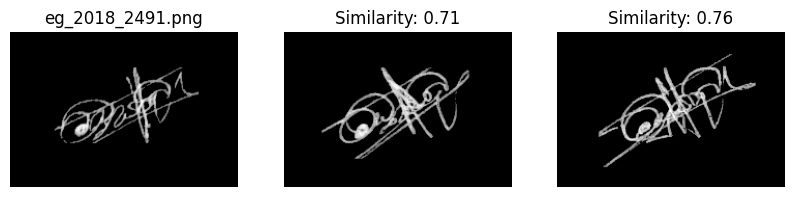

Student: eg_2018_2861.png
Cosine Similarity 1: 0.8866926431655884
Cosine Similarity 2: 0.8939366340637207
Cosine Average: 0.8903146386146545


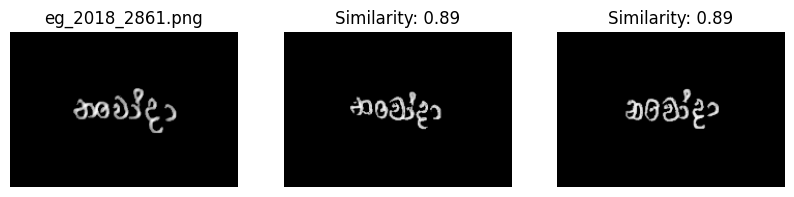

Student: eg_2018_3448.png
Cosine Similarity 1: 0.25573843717575073
Cosine Similarity 2: 0.2576734125614166
Cosine Average: 0.2567059248685837


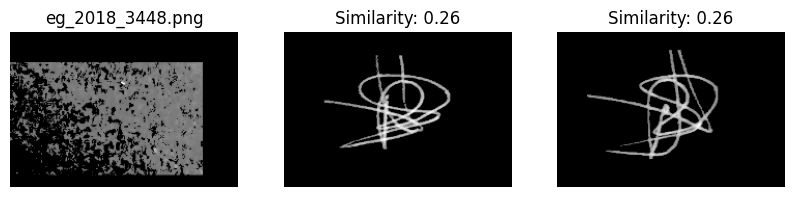

Student: eg_2018_3460.png
Cosine Similarity 1: 0.8006541132926941
Cosine Similarity 2: 0.6049211621284485
Cosine Average: 0.7027876377105713


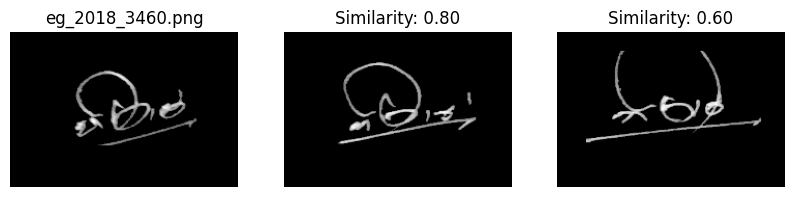

Student: eg_2018_3474.png
Cosine Similarity 1: 0.677934467792511
Cosine Similarity 2: 0.7598085403442383
Cosine Average: 0.7188715040683746


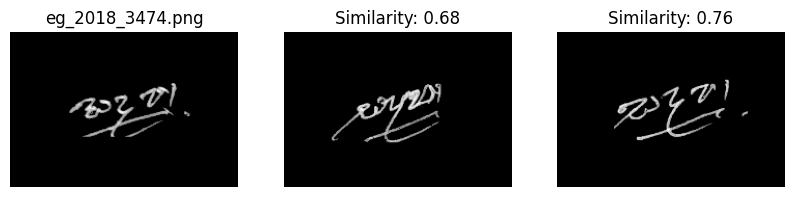

Student: eg_2018_3513.png
Cosine Similarity 1: 0.7625330686569214
Cosine Similarity 2: 0.8058111667633057
Cosine Average: 0.7841721177101135


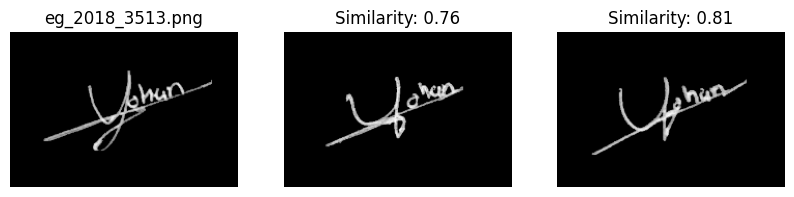

Student: eg_2018_3926.png
Cosine Similarity 1: 0.7125208377838135
Cosine Similarity 2: 0.7360432147979736
Cosine Average: 0.7242820262908936


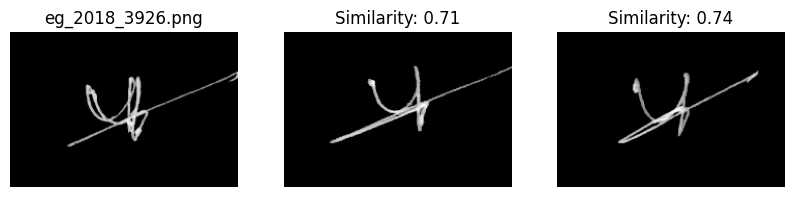

Student: eg_2018_3994.png
Cosine Similarity 1: 0.23791037499904633
Cosine Similarity 2: 0.254459410905838
Cosine Average: 0.24618489295244217


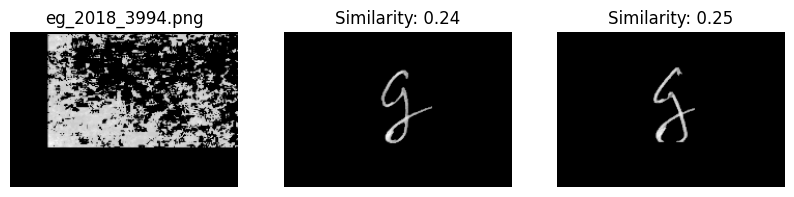

Student: eg_2018_4017.png
Cosine Similarity 1: 0.8081550598144531
Cosine Similarity 2: 0.8601974844932556
Cosine Average: 0.8341762721538544


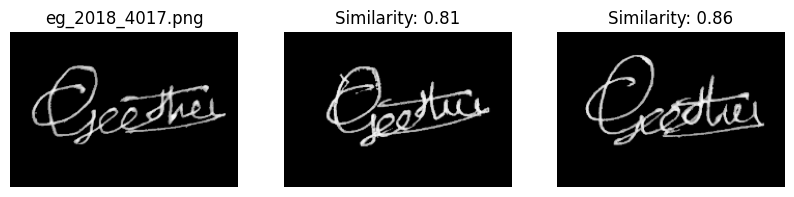

Student: eg_2018_4322.png
Cosine Similarity 1: 0.8611505031585693
Cosine Similarity 2: 0.8827303647994995
Cosine Average: 0.8719404339790344


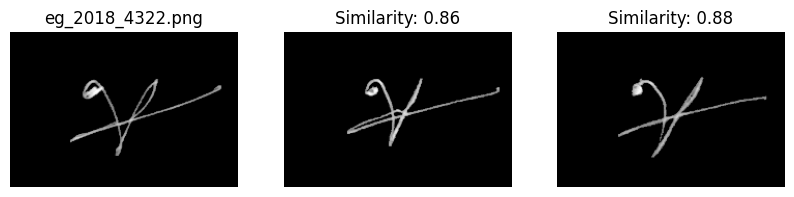

Student: eg_2018_4324.png
Cosine Similarity 1: 0.8302828073501587
Cosine Similarity 2: 0.8323711156845093
Cosine Average: 0.831326961517334


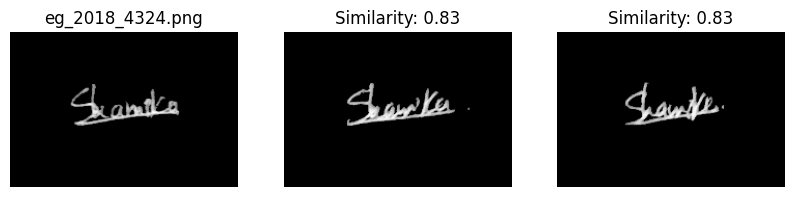

Student: eg_2018_4513.png
Cosine Similarity 1: 0.8429943323135376
Cosine Similarity 2: 0.860509991645813
Cosine Average: 0.8517521619796753


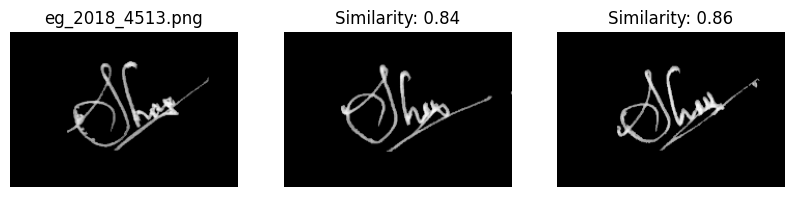

Student: eg_2018_4648.png
Cosine Similarity 1: 0.7877058982849121
Cosine Similarity 2: 0.7617200613021851
Cosine Average: 0.7747129797935486


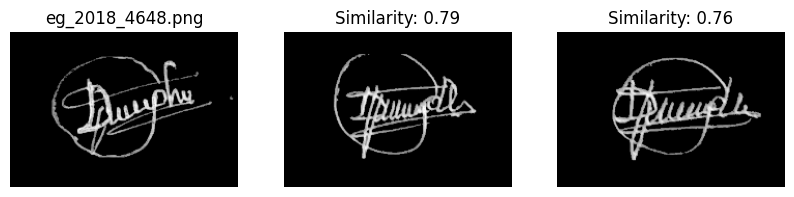

Student: eg_2018_4827.png
Cosine Similarity 1: 0.2290487438440323
Cosine Similarity 2: 0.2557280659675598
Cosine Average: 0.24238840490579605


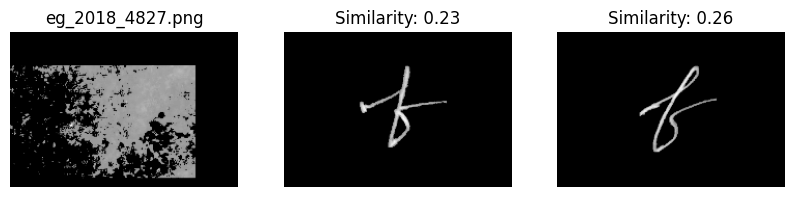

Student: eg_2018_4836.png
Cosine Similarity 1: 0.7412230968475342
Cosine Similarity 2: 0.8101409673690796
Cosine Average: 0.7756820321083069


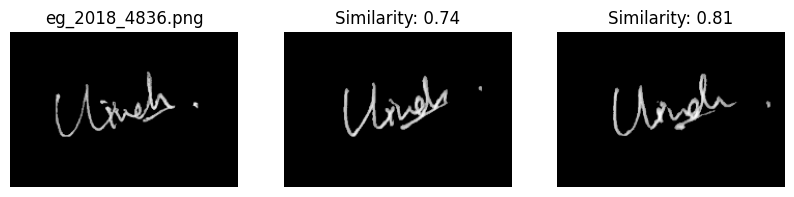

Student: eg_2018_5135.png
Cosine Similarity 1: 0.8868163228034973
Cosine Similarity 2: 0.8937160968780518
Cosine Average: 0.8902662098407745


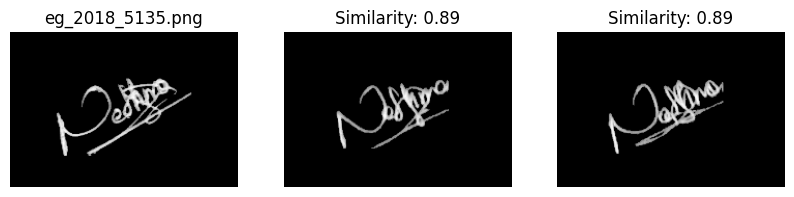

Student: eg_2018_5198.png
Cosine Similarity 1: 0.824691653251648
Cosine Similarity 2: 0.833291232585907
Cosine Average: 0.8289914429187775


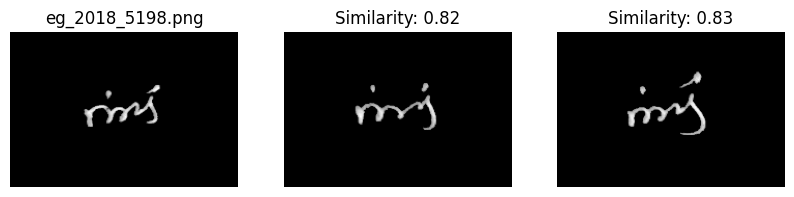

Student: eg_2018_5213.png
Cosine Similarity 1: 0.5950524806976318
Cosine Similarity 2: 0.6597074270248413
Cosine Average: 0.6273799538612366


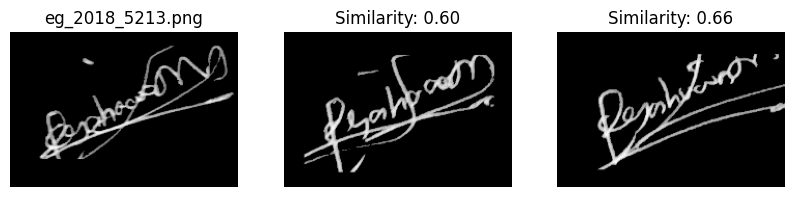

Student: eg_2018_5578.png
Cosine Similarity 1: 0.2654225528240204
Cosine Similarity 2: 0.2691279351711273
Cosine Average: 0.26727524399757385


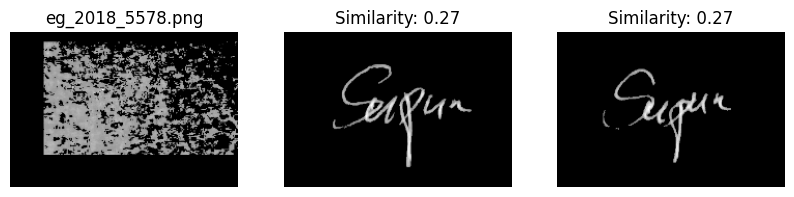

Student: eg_2018_5648.png
Cosine Similarity 1: 0.6786166429519653
Cosine Similarity 2: 0.6304145455360413
Cosine Average: 0.6545155942440033


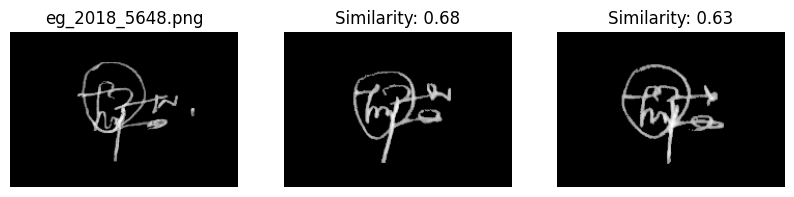

Student: eg_2018_5784.png
Cosine Similarity 1: 0.2803318500518799
Cosine Similarity 2: 0.29493317008018494
Cosine Average: 0.2876325100660324


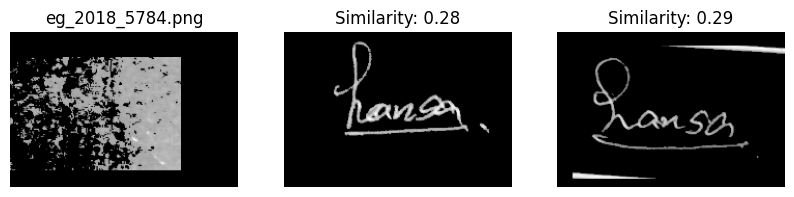

Student: eg_2018_5855.png
Cosine Similarity 1: 0.8417538404464722
Cosine Similarity 2: 0.6235445141792297
Cosine Average: 0.732649177312851


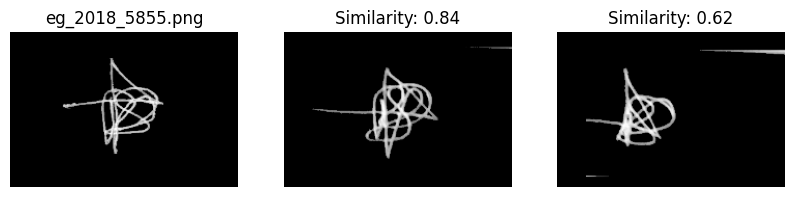

Student: eg_2018_6499.png
Cosine Similarity 1: 0.7078283429145813
Cosine Similarity 2: 0.7402289509773254
Cosine Average: 0.7240286469459534


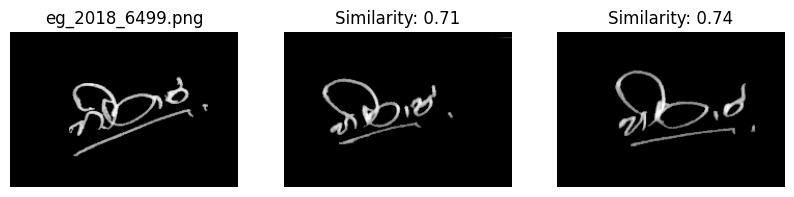

Student: eg_2018_6727.png
Cosine Similarity 1: 0.25324803590774536
Cosine Similarity 2: 0.24760867655277252
Cosine Average: 0.25042835623025894


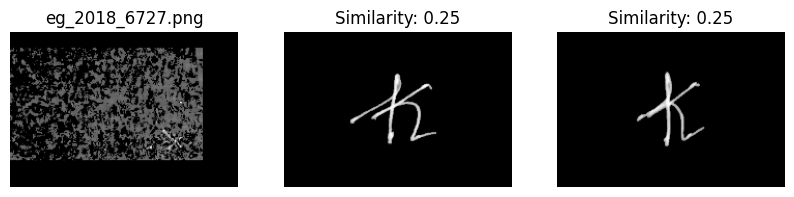

Student: eg_2018_6736.png
Cosine Similarity 1: 0.2807829678058624
Cosine Similarity 2: 0.26931583881378174
Cosine Average: 0.2750494033098221


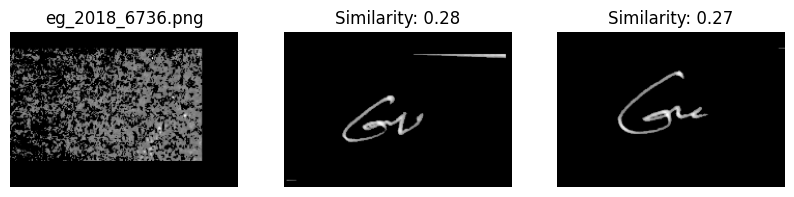

Student: eg_2018_7073.png
Cosine Similarity 1: 0.5273705720901489
Cosine Similarity 2: 0.49012482166290283
Cosine Average: 0.5087476968765259


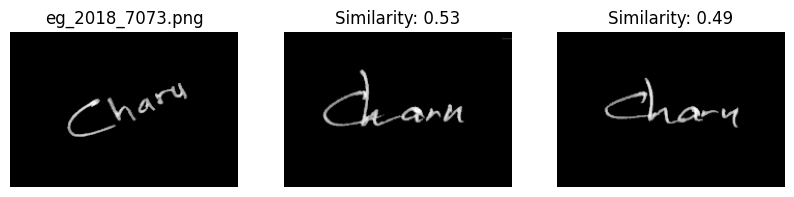

Student: eg_2018_7731.png
Cosine Similarity 1: 0.5342608094215393
Cosine Similarity 2: 0.4091380834579468
Cosine Average: 0.47169944643974304


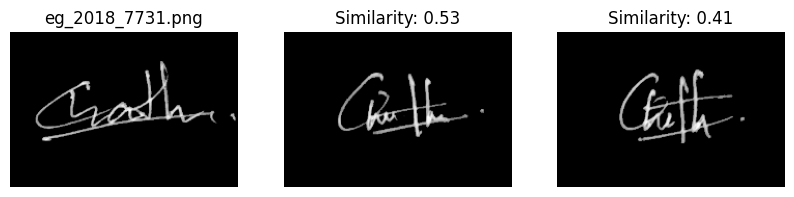

Student: eg_2018_7833.png
Cosine Similarity 1: 0.7927066087722778
Cosine Similarity 2: 0.8469000458717346
Cosine Average: 0.8198033273220062


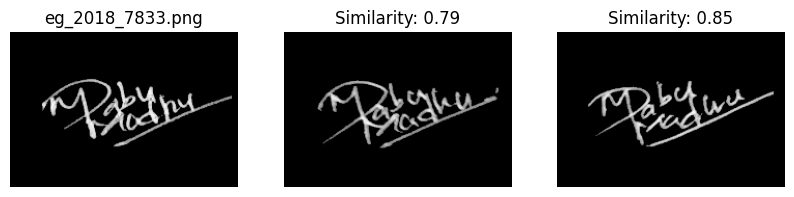

Student: eg_2018_8084.png
Cosine Similarity 1: 0.9025725722312927
Cosine Similarity 2: 0.9200159311294556
Cosine Average: 0.9112942516803741


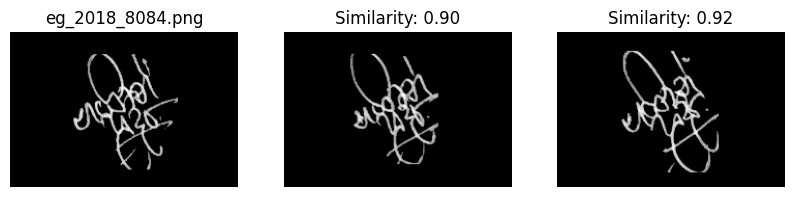

Student: eg_2018_8435.png
Cosine Similarity 1: 0.8125354051589966
Cosine Similarity 2: 0.7204537987709045
Cosine Average: 0.7664946019649506


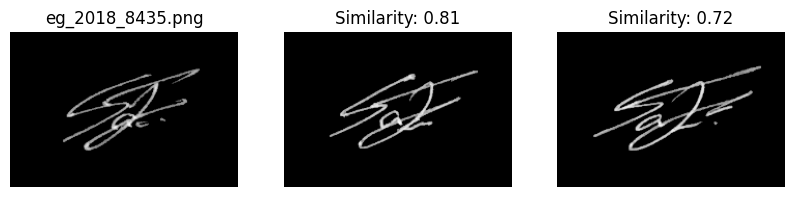

Student: eg_2018_8449.png
Cosine Similarity 1: 0.7778822183609009
Cosine Similarity 2: 0.8064764738082886
Cosine Average: 0.7921793460845947


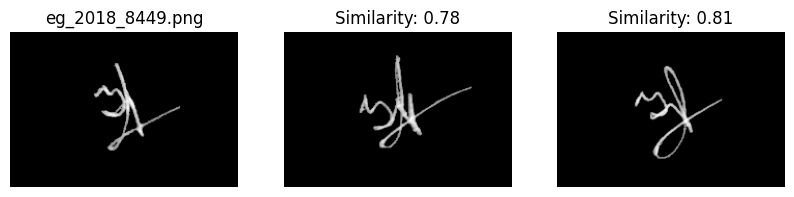

Student: eg_2018_8490.png
Cosine Similarity 1: 0.8278180360794067
Cosine Similarity 2: 0.8541184663772583
Cosine Average: 0.8409682512283325


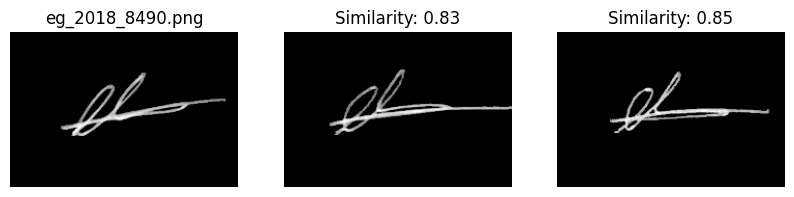

Student: eg_2018_8536.png
Cosine Similarity 1: 0.8364381194114685
Cosine Similarity 2: 0.8300895690917969
Cosine Average: 0.8332638442516327


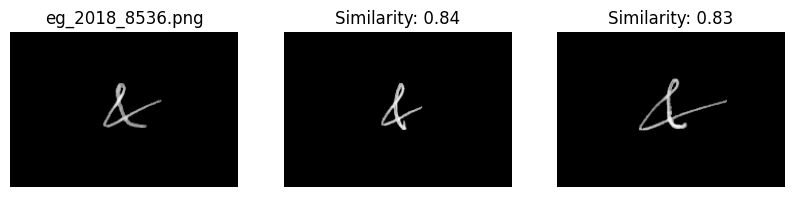

Student: eg_2018_8771.png
Cosine Similarity 1: 0.93361496925354
Cosine Similarity 2: 0.917016863822937
Cosine Average: 0.9253159165382385


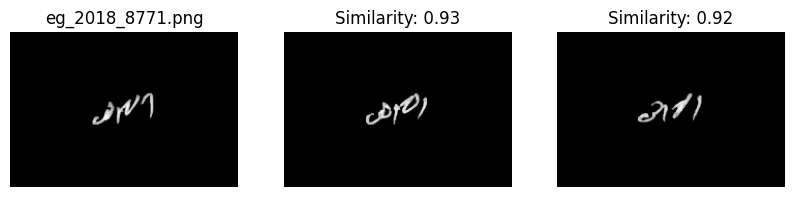

Student: eg_2018_8786.png
Cosine Similarity 1: 0.862371027469635
Cosine Similarity 2: 0.7919045686721802
Cosine Average: 0.8271377980709076


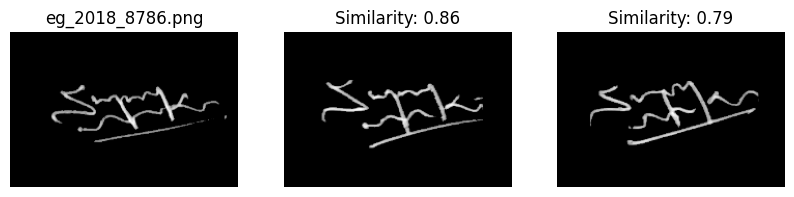

Student: eg_2018_8981.png
Cosine Similarity 1: 0.8160216808319092
Cosine Similarity 2: 0.8662362098693848
Cosine Average: 0.841128945350647


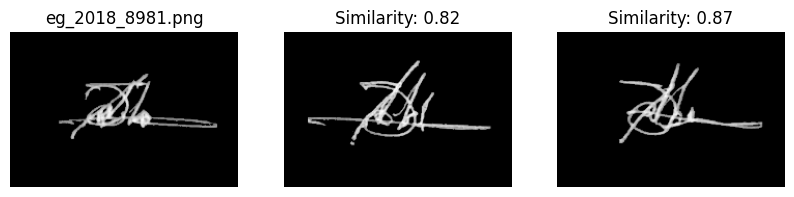

Student: eg_2018_9160.png
Cosine Similarity 1: 0.7673822641372681
Cosine Similarity 2: 0.7835939526557922
Cosine Average: 0.7754881083965302


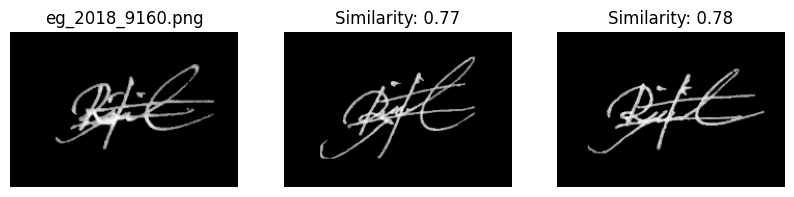

Student: eg_2018_9790.png
Cosine Similarity 1: 0.7552318572998047
Cosine Similarity 2: 0.8006845712661743
Cosine Average: 0.7779582142829895


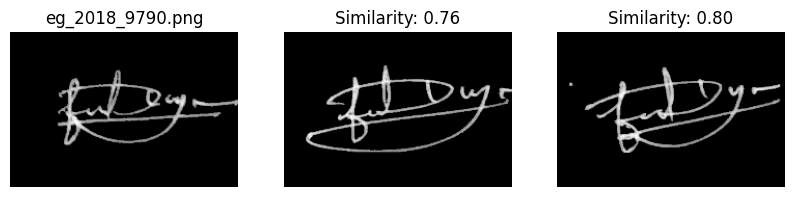

Student: eg_2018_9831.png
Cosine Similarity 1: 0.8005478382110596
Cosine Similarity 2: 0.8197044134140015
Cosine Average: 0.8101261258125305


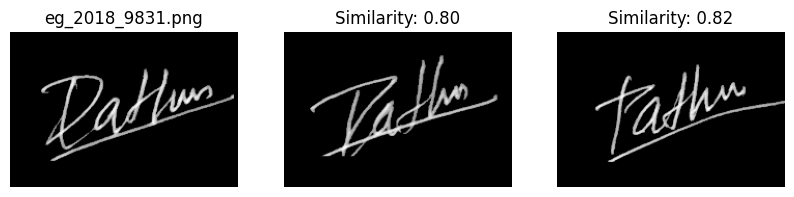

In [73]:
import os
import torch.nn as nn
import torch.nn.functional as F

attendance_path = "../../tmp/processed/attendance/6504c0a30267c540afff568a/0/"
ref_signs_path = "../../tmp/processed/reference_sign_sheets/1694808563737/all/"

signature_files = {}

for file in os.listdir(attendance_path):
    signature_files[file] = {
        "attendance": os.path.join(attendance_path, file),
        "ref_1": os.path.join(ref_signs_path, file.split(".")[0] + "_0.png"),
        "ref_2": os.path.join(ref_signs_path, file.split(".")[0] + "_1.png"),
    }


# f, ax = plt.subplots(len(signature_files), 3, figsize=(10, 6))

logs = []

def process(student, idx):
    sigs_1 = [
        load_signature(signature_files[student]["attendance"]),
        load_signature(signature_files[student]["ref_1"]),
    ]

    sigs_2 = [
        load_signature(signature_files[student]["attendance"]),
        load_signature(signature_files[student]["ref_2"]),
    ]

    processed_sigs_1 = torch.tensor(
        [preprocess_signature(sig, canvas_size) for sig in sigs_1]
    )
    processed_sigs_2 = torch.tensor(
        [preprocess_signature(sig, canvas_size) for sig in sigs_2]
    )

    plt.show()

    processed_sigs_1 = processed_sigs_1.view(-1, 1, 150, 220).float().div(255)
    processed_sigs_2 = processed_sigs_2.view(-1, 1, 150, 220).float().div(255)

    with torch.no_grad():
        features_1 = base_model(processed_sigs_1.to(device))
        features_2 = base_model(processed_sigs_2.to(device))

        # Normalize the tensors (optional, but recommended for cosine similarity)
        tensor1_normalized_0 = F.normalize(features_1[0], dim=0)
        tensor1_normalized_1 = F.normalize(features_1[1], dim=0)
        tensor2_normalized_0 = F.normalize(features_2[0], dim=0)
        tensor2_normalized_1 = F.normalize(features_2[1], dim=0)

        # Calculate the cosine similarity
        cosine_sim_1 = F.cosine_similarity(
            tensor1_normalized_0, tensor1_normalized_1, dim=0
        )
        cosine_sim_2 = F.cosine_similarity(
            tensor2_normalized_0, tensor2_normalized_1, dim=0
        )

        x1 = cosine_sim_1.item()
        x2 = cosine_sim_2.item()

        print("Student:", student)
        print("Cosine Similarity 1:", x1)
        print("Cosine Similarity 2:", x2)

        avrg = (x1 + x2) / 2

        print("Cosine Average:", avrg)
        # print("\n")

        f, ax = plt.subplots(1, 3, figsize=(10, 6))
        plt.title(student)

        ax[0].imshow(processed_sigs_1[0].squeeze(), cmap="gray")
        ax[0].set_title(student)
        ax[0].axis("off")

        ax[1].imshow(processed_sigs_1[1].squeeze(), cmap="gray")
        ax[1].set_title(f"Similarity: {cosine_sim_1.item():.2f}")
        ax[1].axis("off")

        ax[2].imshow(processed_sigs_2[1].squeeze(), cmap="gray")
        ax[2].set_title(f"Similarity: {cosine_sim_2.item():.2f}")
        ax[2].axis("off")

        # save image
        plt.savefig(f"../../tmp/processed/verification/{student}.png")

        plt.show()

        id = student.split('.')[0].upper().replace('_', '/')

        no_log = [2432, 3448, 3994, 4827, 5578, 5784, 6727, 6736]
        no_log = [f'EG/2018/{line}' for line in no_log]

        if id in no_log:
            return

        threshold = 0.79
        tolerance = 0.04

        status = None

        if x1 > threshold or x2 > threshold:
            status = 'Genuine'
        elif x1 > threshold - tolerance or x2 > threshold - tolerance:
            status = 'Pending'
        else:
            status = 'Forged'
        
        # if any of the cosine similarity is more than the threshold, then it is a forgery
      



        logs.append('\\hline')
        logs.append(f'{id} & {x1:.2f} & {x2:.2f} & {status} \\\\')


        # \hline
        # EG/2018/0159 & 0.77 & 0.80 & 0.33 & Genuine & \\ 



for idx, student in enumerate(signature_files):
    process(student, idx)

In [72]:
# EG/2018/0159 & 0. & 0.85 & 0.84 & Genuine\\
# print(len(logs))
for l in logs:
    print(l)

\hline
EG/2018/0159 & 0.81 & 0.83 & Genuine \\
\hline
EG/2018/0198 & 0.63 & 0.66 & Forged \\
\hline
EG/2018/0402 & 0.73 & 0.69 & Forged \\
\hline
EG/2018/0628 & 0.84 & 0.92 & Genuine \\
\hline
EG/2018/0806 & 0.65 & 0.72 & Forged \\
\hline
EG/2018/0947 & 0.80 & 0.77 & Genuine \\
\hline
EG/2018/1529 & 0.77 & 0.87 & Genuine \\
\hline
EG/2018/1840 & 0.83 & 0.79 & Genuine \\
\hline
EG/2018/2170 & 0.81 & 0.68 & Genuine \\
\hline
EG/2018/2347 & 0.85 & 0.80 & Genuine \\
\hline
EG/2018/2491 & 0.71 & 0.76 & Pending \\
\hline
EG/2018/2861 & 0.89 & 0.89 & Genuine \\
\hline
EG/2018/3460 & 0.80 & 0.60 & Genuine \\
\hline
EG/2018/3474 & 0.68 & 0.76 & Pending \\
\hline
EG/2018/3513 & 0.76 & 0.81 & Genuine \\
\hline
EG/2018/3926 & 0.71 & 0.74 & Forged \\
\hline
EG/2018/4017 & 0.81 & 0.86 & Genuine \\
\hline
EG/2018/4322 & 0.86 & 0.88 & Genuine \\
\hline
EG/2018/4324 & 0.83 & 0.83 & Genuine \\
\hline
EG/2018/4513 & 0.84 & 0.86 & Genuine \\
\hline
EG/2018/4648 & 0.79 & 0.76 & Pending \\
\hline
EG/2018/48